In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nivapy3 as nivapy
from scipy.stats import pearsonr
from scipy.stats import spearmanr

import matplotlib as mpl
mpl.rcParams["figure.facecolor"]
mpl.rcParams["axes.facecolor"]
mpl.rcParams["savefig.facecolor"]
# plt.style.use('ggplot')

'auto'

In [2]:
site = "Malselva"  # Malselva or Storelva

start_date_dict = {"Malselva": "2017-01-01",
                   "Storelva": "2017-01-01"}  # Tho have data from 2016

# For naming plots and files
site_name_dict = {"Malselva": "Målselva",
                  "Storelva": "Storelva"}

# Read in data

## Read in sensor data

In [3]:
fpath = r'../2022_MD/data/sensor_%s.csv' % site

sensor_df_hourly = pd.read_csv(fpath, index_col=1, parse_dates=True, na_values="NA")
sensor_df_hourly = sensor_df_hourly.drop('station_name', axis=1)
sensor_df_hourly.columns = ["FDOM", "Conductivity", "pH", "T_water", "Turbidity"]
sensor_df_hourly.dropna(how="all", axis=0, inplace=True)

# Remove UTC timezone info. N.B. need to double-check this was always 0
# In future, also need to double-check summer time vs winter time for both sensors
# and grab samples
sensor_df_hourly.index = sensor_df_hourly.index.tz_localize(None)

sensor_df_hourly

,FDOM,Conductivity,pH,T_water,Turbidity
datetime,,,,,
2018-01-01 00:00:00,11.14,4.942,7.459,0.004,NaN
2018-01-01 01:00:00,10.89,4.940,7.453,0.010,NaN
2018-01-01 02:00:00,10.94,4.924,7.437,0.008,NaN
2018-01-01 03:00:00,11.04,4.904,7.459,0.003,NaN
2018-01-01 04:00:00,10.94,4.876,7.462,0.007,NaN
...,...,...,...,...,...
2021-12-30 20:00:00,NaN,NaN,7.290,0.158,2.05
2021-12-30 21:00:00,NaN,NaN,7.281,0.159,2.06
2021-12-30 22:00:00,NaN,NaN,7.267,0.162,2.06


In [4]:
# Round sensor data timestamp to the nearest hour, for joining with Q and grab sample data
sensor_df_hourly.index = sensor_df_hourly.index.round(freq='H')
sensor_df_hourly.sort_index(inplace=True)  # Not sure it was sorted; do in case
sensor_df_hourly.head(2)

,FDOM,Conductivity,pH,T_water,Turbidity
datetime,,,,,
2018-01-01 00:00:00,11.14,4.942,7.459,0.004,NaN
2018-01-01 01:00:00,10.89,4.940,7.453,0.010,NaN


In [5]:
# Resample to daily
sensor_df = sensor_df_hourly.resample('D').mean()

# Drop time info for joining and plotting
sensor_df.index = pd.to_datetime(sensor_df.index).normalize()

sensor_df.to_csv(r'../data/sensor/malselva_sensor_daily_2018-2021.csv')

sensor_df

,FDOM,Conductivity,pH,T_water,Turbidity
datetime,,,,,
2018-01-01,11.065417,4.930958,7.453875,0.005750,NaN
2018-01-02,10.982500,5.267292,7.446125,0.006167,NaN
2018-01-03,10.800000,5.097292,7.432292,0.005625,NaN
2018-01-04,10.571667,5.219750,7.435583,0.004958,NaN
2018-01-05,10.526667,4.797000,7.442167,0.004083,NaN
...,...,...,...,...,...
2021-12-27,NaN,NaN,7.320083,0.156750,2.562500
2021-12-28,NaN,NaN,7.313333,0.158042,2.428750
2021-12-29,NaN,NaN,7.314125,0.157542,2.194167


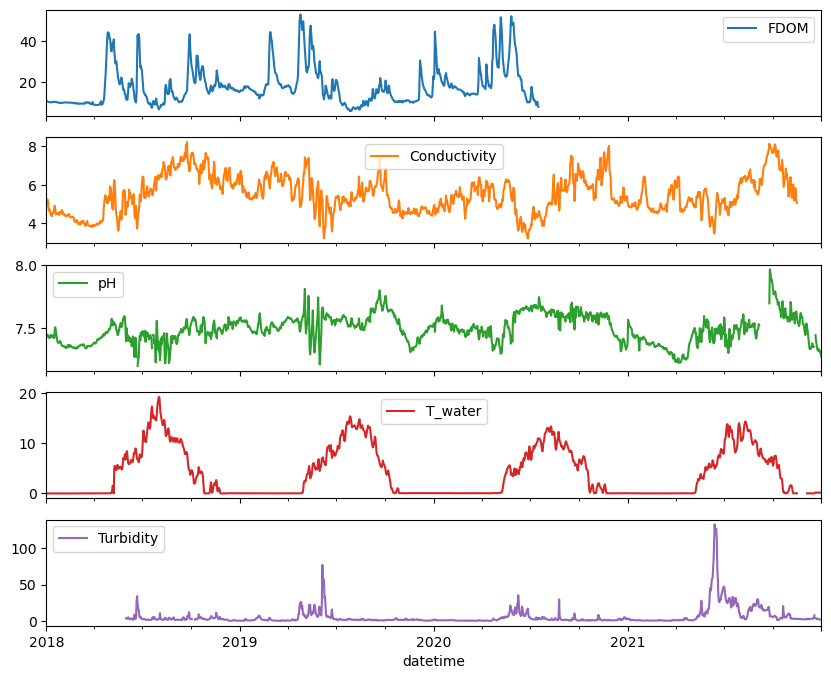

In [6]:
sensor_df.plot(subplots=True, sharex=True, figsize=(10, 8));

### QC issues with sensor data
* To improve on. E.g. FDOM data exists after 2020, but step change that needs looking into, so we dropped it for the (rushed) MD work in 2022. So needs re-downloading from Aquamonitor.

**STILL NEED FIXING**

## Read in discharge data

In [6]:
# Daily
q_series = pd.read_csv(
    r"../data/discharge/Q_målselva_daily-mean_area-scaled_2017-2022.csv",
    index_col=0,
    parse_dates=True,
).squeeze()

# Drop time info for joining and plotting
q_series.index = pd.to_datetime(q_series.index).normalize().tz_localize(None)

q_series.name = "Q"
q_series

datetime
2017-01-01    38.65181
2017-01-02    33.81447
2017-01-03    28.81786
2017-01-04    29.48046
2017-01-05    32.36790
                ...   
2022-12-27    50.79718
2022-12-28    47.55765
2022-12-29    44.73127
2022-12-30    41.72360
2022-12-31    40.11220
Name: Q, Length: 2191, dtype: float64

## Read in grab sample water chem data

In [7]:
chem_df = pd.read_csv(r'../data/water_chem/malselva_am-export_2018-2022.csv', index_col=0, parse_dates=True)

# Drop first column which is station ID
chem_df.drop(chem_df.columns[0], axis=1, inplace=True)

# Drop rows where there were no samples at all
chem_df.dropna(axis=0, how="all", inplace=True)

# Drop time info for joining and plotting with daily data
chem_df.index = pd.to_datetime(chem_df.index).normalize().tz_localize(None)
chem_df.sort_index(inplace=True)  # Not sure it was sorted; do in case

# Add column for joining with rest of data, simple boolean saying there was a sample this date
chem_df['grab_sample'] = True

chem_df.tail()

,Cl,DOC,K,Konduktivitet,Mg,NH4-N,NO3-N,Na,N_Part,TRP,...,TP,TDP,PP,SPM,UV-Abs. 254nm,UV-Abs. 285nm,UV-Abs. 365nm,UV-Abs. 410nm,pH,grab_sample
sample_date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,1.36,1.10,0.70,6.89,1.53,2.0,19.0,1.28,12.70,1.0,...,3.0,NaN,3.0,1.23,0.036104,0.025428,0.007068,0.003114,7.63,True
2022-09-05,1.20,0.92,0.75,7.20,1.61,25.0,18.0,1.39,18.70,1.0,...,2.0,NaN,2.0,1.15,0.031250,0.021636,0.005804,0.002744,7.69,True
2022-10-03,1.52,0.87,0.73,7.12,1.66,2.0,28.0,1.37,17.80,1.0,...,2.0,NaN,2.0,1.08,0.027486,0.018772,0.004940,0.002280,7.62,True
2022-11-07,1.90,1.30,0.79,8.32,1.90,9.0,48.0,1.68,10.20,2.0,...,3.0,NaN,3.0,2.09,0.046454,0.032772,0.009464,0.004446,7.68,True
2022-12-05,1.96,0.90,0.95,9.63,2.21,10.0,74.0,1.62,6.35,1.0,...,2.0,NaN,2.0,0.94,0.027240,0.018894,0.004976,0.002148,7.48,True


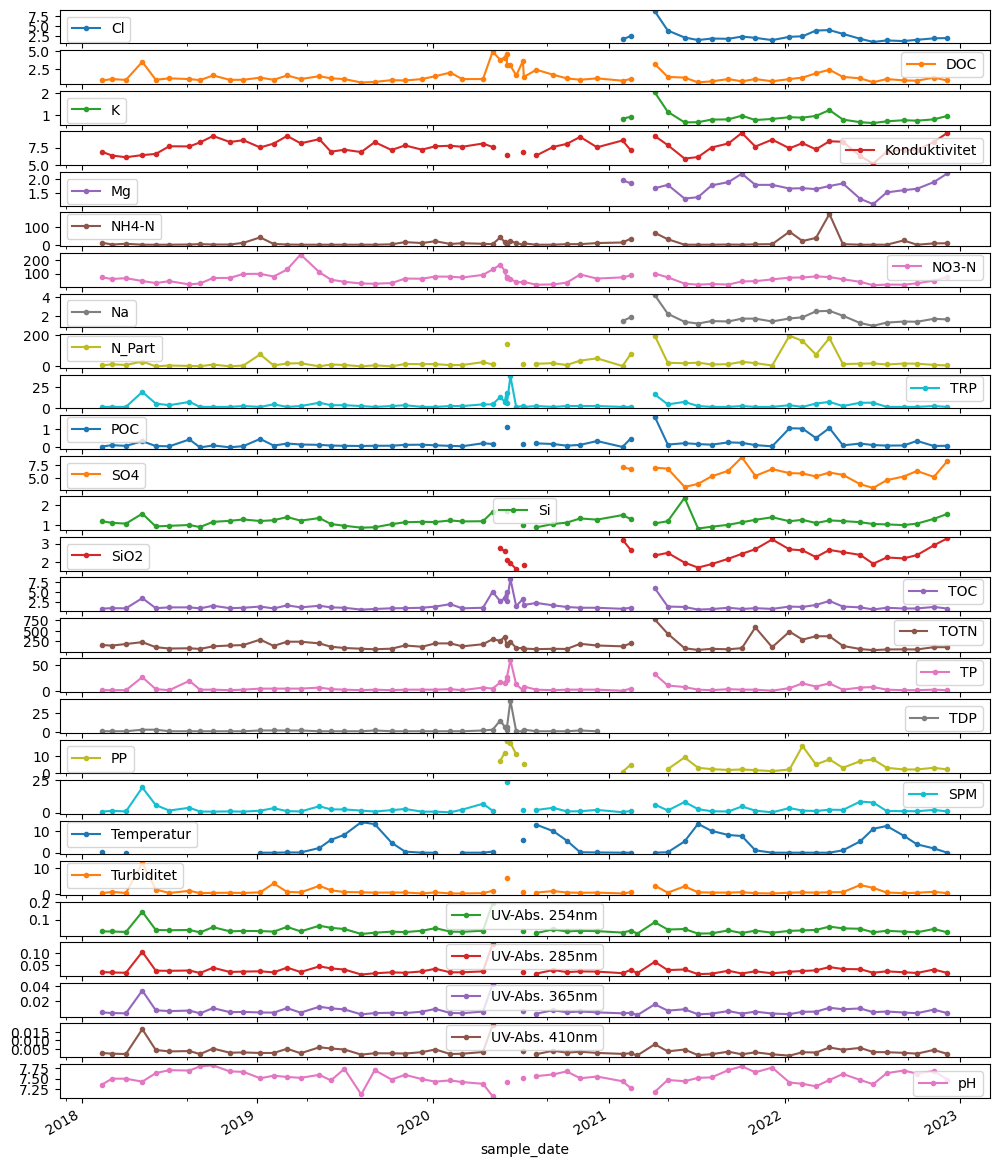

In [9]:
chem_df.plot(subplots=True, sharex=True, figsize=(12, 16), marker='o', markersize=3);

**QC**
* **The 2020 Målselva DOC data are suspiciously high. Real, and because of higher frequency sampling during freshet??
* There's one point in the Målselva grab sample DOC data that I don't believe. Over 2 days there's a huge change in DOC, which isn't seen in FDOM, and there's not much change in Q either. It's a real outlier on the FDOM:DOC plot. So decide to delete that point.

In [8]:
# Drop dodgy data
chem_df.loc['2020-07-06', 'DOC'] = np.NaN

**DODGYNESS HERE**. More QC of the chem data is needed. E.g. IQR of DOC > that of TOC. Which is more reliable?

# Join and plot data

## Daily: All but grab samples

In [9]:
df_li = [q_series, sensor_df, chem_df['grab_sample']]
df = pd.concat(df_li, axis=1, sort=True)

# Fill in 0s for days when there weren't grab samples
df.loc[df['grab_sample'] != 1, 'grab_sample'] = False

# index = pd.to_datetime(df.index, yearfirst=True)
# df.index = index

# Truncate to desired start date
start_date = start_date_dict[site]
df = df.loc[start_date:]

# df.to_csv(r'../data/malselva_continuous_vars.csv')

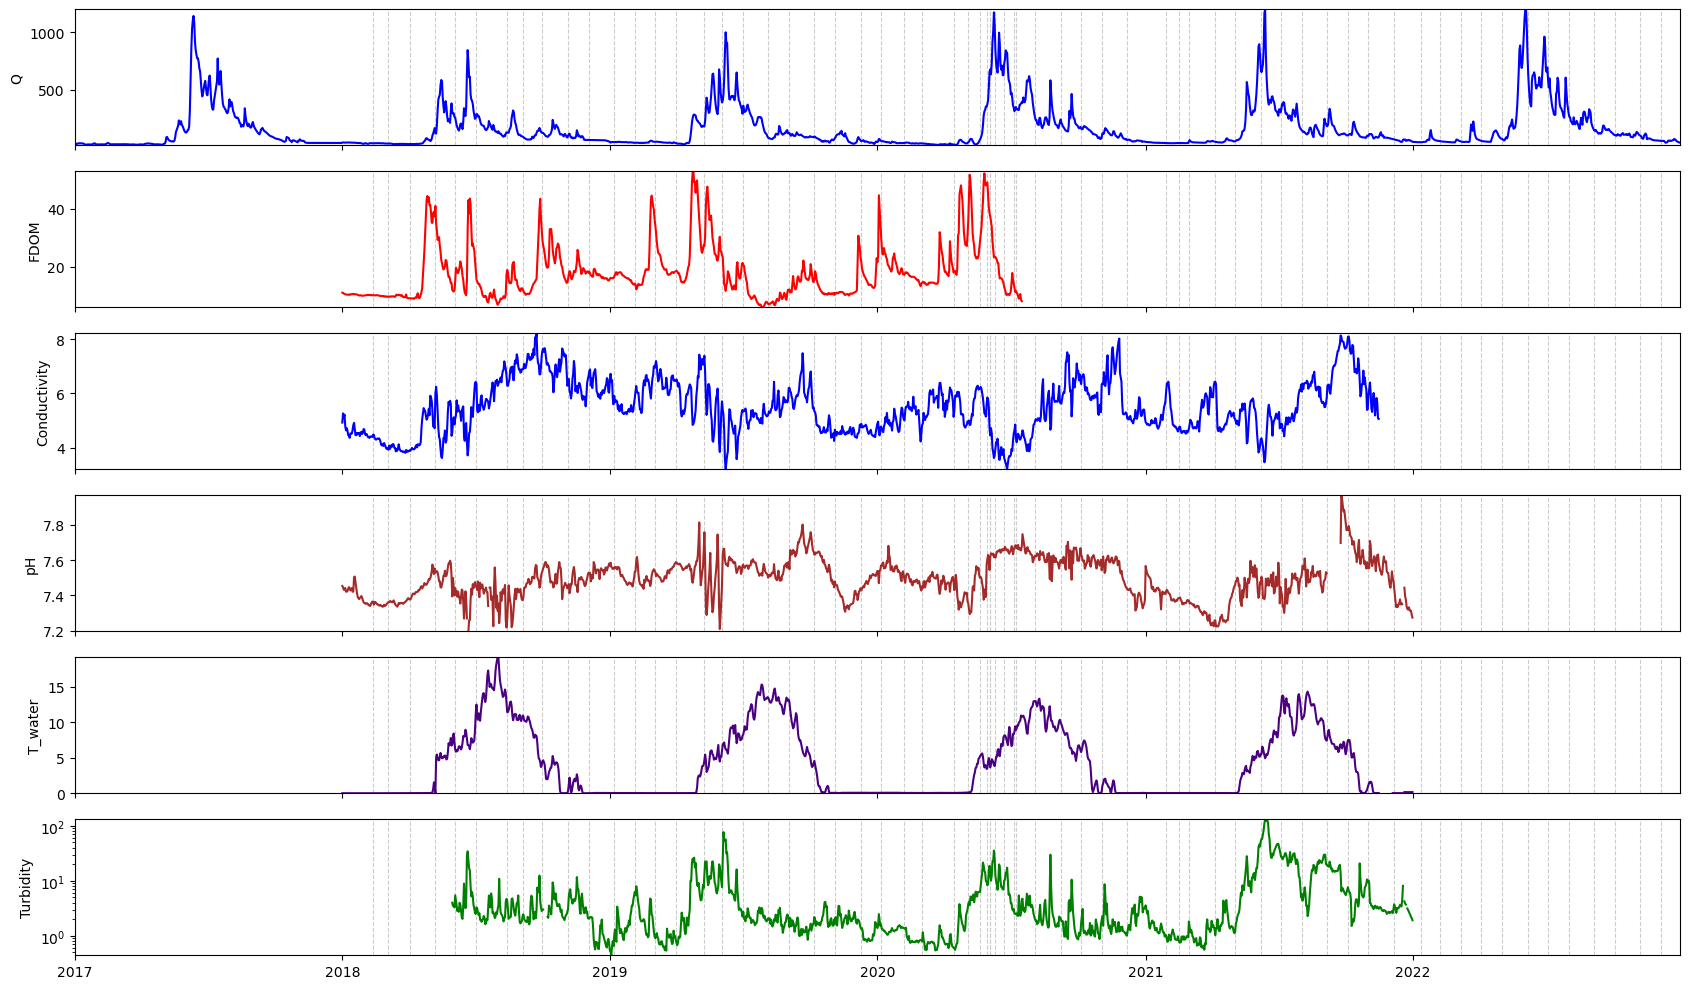

In [10]:
# Get sampling dates for plotting below
samp_dates = df.loc[df['grab_sample'] == True].index.values

colours = ['blue', 'red', 'blue', 'brown', 'indigo', 'green', 'red', 'black']

fig, axs = plt.subplots(len(df.columns)-1, 1, sharex=True, figsize=(17, 10))

for i, var in enumerate(df.columns[:-1]):
    # Plot sampling dates as vertical lines
    for date in samp_dates:
        axs[i].axvline(date, color='0.8', linestyle='--', linewidth=0.8)

    axs[i].plot(df.index, df[var], marker='', color=colours[i])

    axs[i].set_ylabel(df.columns[i])
    if var == 'Turbidity':
        axs[i].set_yscale("log")

    # Sort out xaxis limits (the buffer was too big by default)
    axs[i].margins(0.0)

# plt.suptitle("%s" % site_name_dict[site], size=12);
plt.tight_layout()
plt.savefig(r'../figures/timeseries_all-cont-data_%s.png' % site, dpi=150)

## Add season info

**Define 3 or 4 seasons a year. Also whether or not it's freshet**

Spring freshet dates according to FLLINK snow coverage data for the full 0-2500m band at 20% threshold:

* 2018: Starts mid-April. Snow gone by end of June, and all the snow that was gonna melt that year gone by around June 8th
* 2019: Start mid-April. Snow gone by end of July, but 
* 2020: Start at start of April. Snow gone by start of August.

For now, we have decided to just classify freshet as May-June

In [11]:
# Define 3 seasons per year or freshet or not
def season(x):
    """Input month number, and return the season it corresponds to
    """
    if x in [5, 6]:
        return 'spring'
    if x in [7, 8]:
        return 'summer'
    else:
        return 'winter'


def freshet(x):
    """Input month number, return whether freshet or not"""
    if x in [5, 6]:
        return 'Freshet'
    else:
        return 'Not freshet'

In [12]:
df["Season"] = df.index.month.map(season)
df["Freshet"] = df.index.month.map(freshet)
df.loc[['2020-03-31', '2020-04-01', '2020-06-30', '2020-07-01', '2020-09-30', '2020-10-01']]

,Q,FDOM,Conductivity,pH,T_water,Turbidity,grab_sample,Season,Freshet
2020-03-31,26.54453,21.155417,5.387417,7.511625,0.045250,0.858750,False,winter,Not freshet
2020-04-01,27.16879,19.838750,5.643750,7.492542,0.039625,0.804167,False,winter,Not freshet
2020-06-30,544.96715,10.736250,3.689625,7.648333,8.627583,5.360833,False,spring,Freshet
2020-07-01,460.28952,11.529167,3.730875,7.652708,7.276750,3.917500,False,summer,Not freshet
2020-09-30,188.52336,NaN,6.787792,7.596458,6.251875,0.883333,False,winter,Not freshet
2020-10-01,177.79067,NaN,6.827292,7.608167,6.738458,0.863478,False,winter,Not freshet


# Regressions

Use Nivapy. N.B. Best subsets with one combo is the same as 'normal' OLS

In [13]:
def make_regression_df(cont_df, cont_var, chem_df, chem_var):
    s_li = [cont_df[cont_var], chem_df[chem_var]]
    reg_df = pd.concat(s_li, axis=1, join='inner', sort=True)
    reg_df.columns = [cont_var, chem_var]
    reg_df.index = pd.to_datetime(reg_df.index, yearfirst=True)
    reg_df['Freshet'] = reg_df.index.month.map(freshet)
    reg_df.dropna(how='any', inplace=True)

    return reg_df

## DOC from FDOM

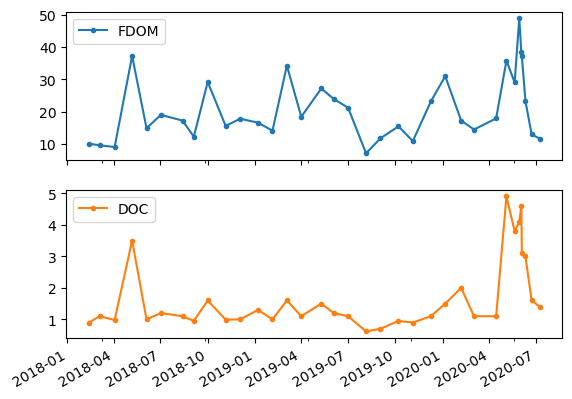

In [19]:
doc_fdom_reg_df = make_regression_df(sensor_df, 'FDOM', chem_df, 'DOC')
doc_fdom_reg_df.plot(subplots=True, sharex=True, marker='o', ms=3);

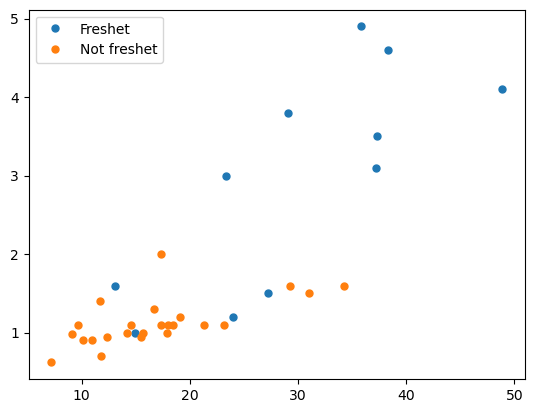

In [20]:
# Plot raw data grouped by season
groups = doc_fdom_reg_df.groupby("Freshet")
fig, ax = plt.subplots()
for season, group in groups:
    ax.plot(group['FDOM'], group['DOC'], marker='o', linestyle='', ms=5, label=season)
ax.legend()

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                    DOC   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     59.66
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           6.76e-09
Time:                        20:15:50   Log-Likelihood:                -36.470
No. Observations:                  35   AIC:                             76.94
Df Residuals:                      33   BIC:                             80.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

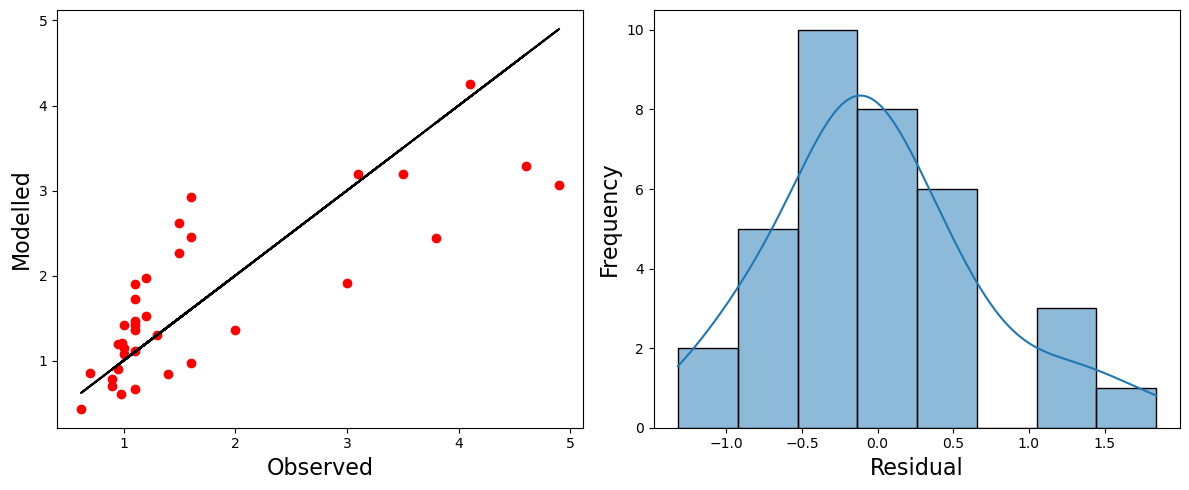

In [22]:
# No seasonal grouping
doc_res, scalar = nivapy.stats.best_subsets_ols_regression(
    doc_fdom_reg_df.dropna(how='any'),
    'DOC',
    ['FDOM'],
    standardise=False,
)

print(doc_res.params)

#############################################################
# Freshet
Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                    DOC   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     13.59
Date:                Fri, 20 Oct 2023   Prob (F-statistic):            0.00503
Time:                        20:16:33   Log-Likelihood:                -13.748
No. Observations:                  11   AIC:                             31.50
Df Residuals:                       9   BIC:                             32.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


#############################################################
# Not freshet
Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                    DOC   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     14.86
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           0.000858
Time:                        20:16:33   Log-Likelihood:                 1.1525
No. Observations:                  24   AIC:                             1.695
Df Residuals:                      22   BIC:                             4.051
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


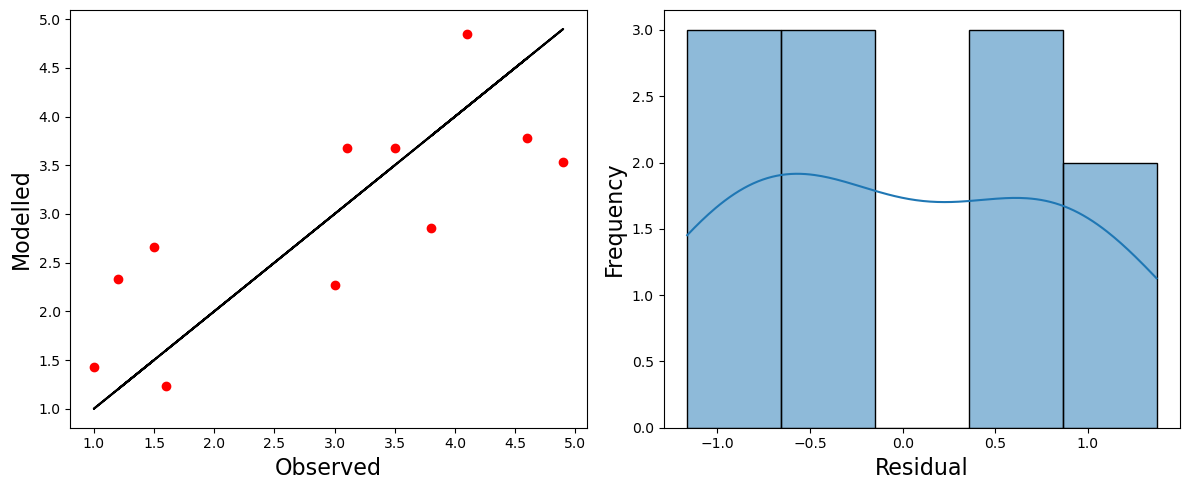

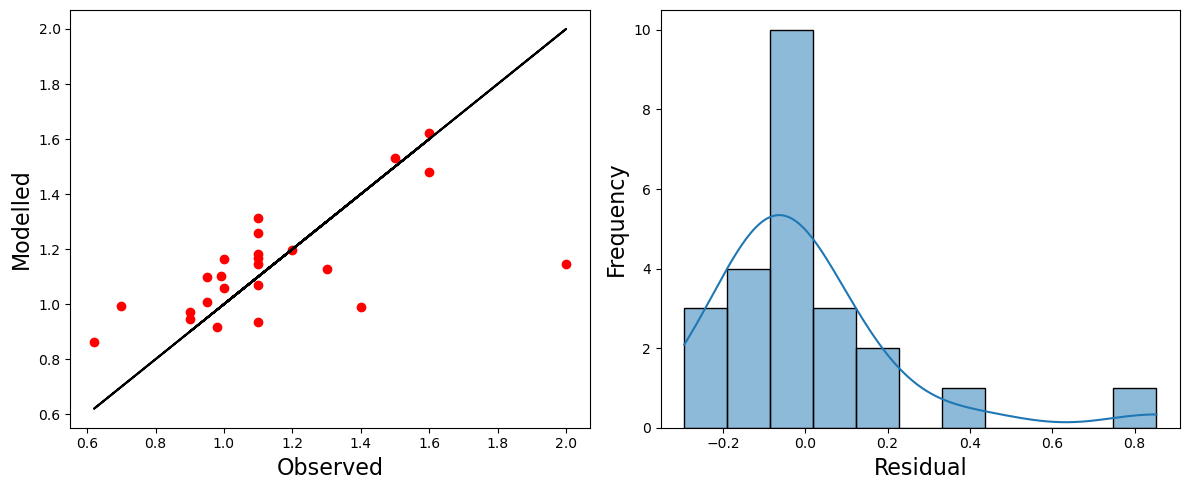

In [25]:
# Regression grouping by Freshet or not
groups = doc_fdom_reg_df.groupby("Freshet")

doc_coeffs_dict = {}  # key: bool for freshet or not, returns dict{m: x, c:y}

for season, group_df in groups:
    print('#############################################################')
    print(f'# {season}')
    # Best subsets with one combo is the same as 'normal' OLS
    res, scalar = nivapy.stats.best_subsets_ols_regression(
        group_df,
        'DOC',
        ['FDOM'],
        standardise=False,
    )

    # Save params
    doc_coeffs_dict[season] = res.params

In [26]:
doc_coeffs_dict

{'Freshet': const   -0.078698
 FDOM     0.100749
 dtype: float64,
 'Not freshet': const    0.663362
 FDOM     0.027984
 dtype: float64}

## SPM from turbidity

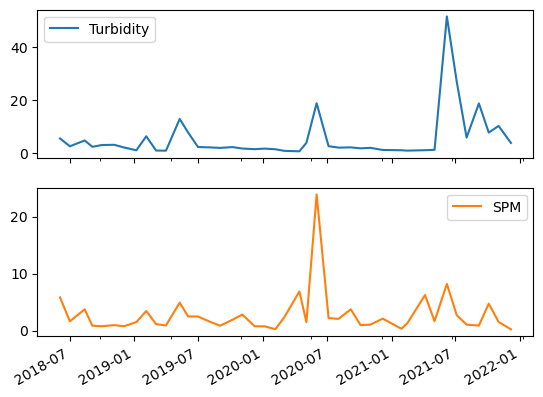

In [28]:
spm_reg_df = make_regression_df(sensor_df, 'Turbidity', chem_df, 'SPM')
spm_reg_df.plot(subplots=True, sharex=True);

<Axes: xlabel='Turbidity'>

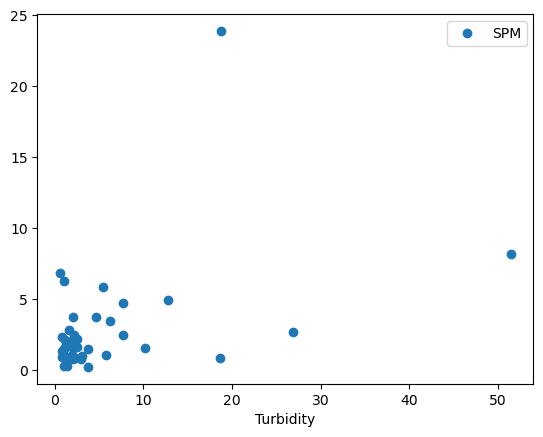

In [29]:
spm_reg_df.plot(x='Turbidity', y='SPM', marker='o', linestyle='');

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                    SPM   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     9.019
Date:                Fri, 20 Oct 2023   Prob (F-statistic):            0.00459
Time:                        20:17:56   Log-Likelihood:                -111.27
No. Observations:                  42   AIC:                             226.5
Df Residuals:                      40   BIC:                             230.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

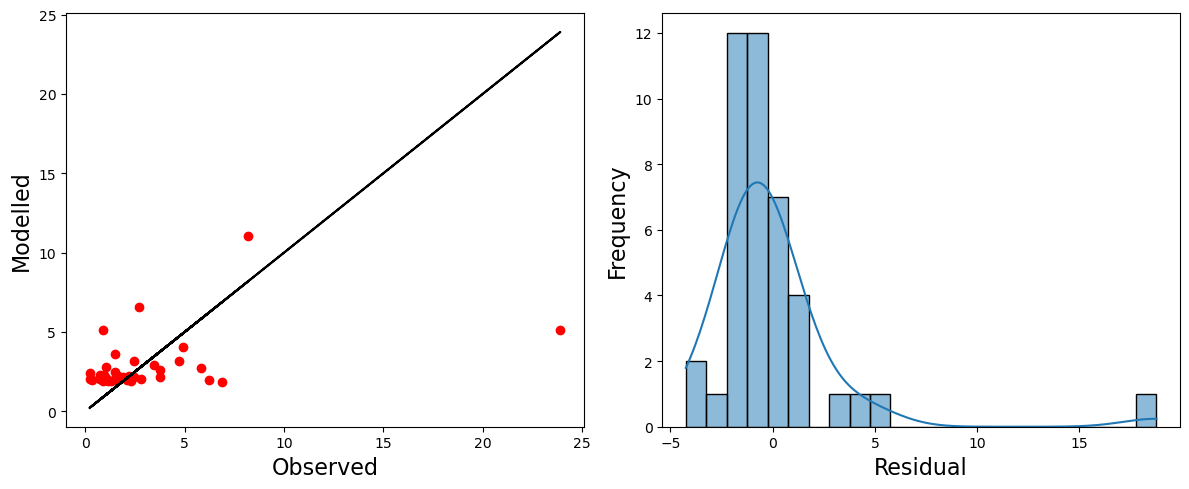

In [30]:
# No season split
spm_res, scalar = nivapy.stats.best_subsets_ols_regression(
    spm_reg_df,
    'SPM',
    ['Turbidity'],
    standardise=False,
)

Not a good relationship between turbidity and SPM. Even worse when do a season split (deleted from here for now). Try SPM vs Q instead

**TO do**: Try out other chemical variables vs sensor variables

# Fluxes

3 ways of calculating daily fluxes:
1) Linear interpolation of grab samples
2) Relationships between sensor data and grab samples, for Målselva split by freshet vs not.
3) Relationships between Q data and grab samples (e.g. for SPM?). To investigate still.

## Estimate daily concentrations

Linear interpolation as the default. There are some larger data gaps, but not enormous, so just do for all variables and years.

Then for variables which show decent relationships with continuous data, replace with that instead.

### Linear interpolation

In [15]:
# Drop non-numerate columns
chem_df = chem_df.select_dtypes(include=[np.number])

# Interpolate all grab samples
chem_daily_df = chem_df.asfreq('D')
print(chem_daily_df['DOC'].isna().sum())
chem_daily_df = chem_daily_df.interpolate(method='time')
print(chem_daily_df['DOC'].isna().sum())

chem_daily_df.to_csv(r'../data/water_chem/malselva_waterchem_daily_interpolated_2018-2022.csv')

chem_daily_df

1695
0


,Cl,DOC,K,Konduktivitet,Mg,NH4-N,NO3-N,Na,N_Part,TRP,...,TOTN,TP,TDP,PP,SPM,UV-Abs. 254nm,UV-Abs. 285nm,UV-Abs. 365nm,UV-Abs. 410nm,pH
sample_date,,,,,,,,,,,,,,,,,,,,,
2018-02-12,NaN,0.900000,NaN,6.890000,NaN,13.000000,72.000000,NaN,6.700000,1.000000,...,160.000000,2.000000,1.0,NaN,0.790000,0.032734,0.022252,0.005926,0.002694,7.360000
2018-02-13,NaN,0.909524,NaN,6.864286,NaN,12.523810,71.428571,NaN,7.028571,1.000000,...,159.428571,2.000000,1.0,NaN,0.818571,0.032703,0.022182,0.005889,0.002672,7.366667
2018-02-14,NaN,0.919048,NaN,6.838571,NaN,12.047619,70.857143,NaN,7.357143,1.000000,...,158.857143,2.000000,1.0,NaN,0.847143,0.032673,0.022112,0.005851,0.002651,7.373333
2018-02-15,NaN,0.928571,NaN,6.812857,NaN,11.571429,70.285714,NaN,7.685714,1.000000,...,158.285714,2.000000,1.0,NaN,0.875714,0.032642,0.022042,0.005814,0.002629,7.380000
2018-02-16,NaN,0.938095,NaN,6.787143,NaN,11.095238,69.714286,NaN,8.014286,1.000000,...,157.714286,2.000000,1.0,NaN,0.904286,0.032611,0.021972,0.005776,0.002607,7.386667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,1.951429,0.957143,0.927143,9.442857,2.165714,9.857143,70.285714,1.628571,6.900000,1.142857,...,110.000000,2.142857,1.0,2.142857,1.104286,0.029985,0.020877,0.005617,0.002476,7.508571
2022-12-02,1.953571,0.942857,0.932857,9.489643,2.176786,9.892857,71.214286,1.626429,6.762500,1.107143,...,110.000000,2.107143,1.0,2.107143,1.063214,0.029299,0.020381,0.005457,0.002394,7.501429
2022-12-03,1.955714,0.928571,0.938571,9.536429,2.187857,9.928571,72.142857,1.624286,6.625000,1.071429,...,110.000000,2.071429,1.0,2.071429,1.022143,0.028612,0.019885,0.005297,0.002312,7.494286


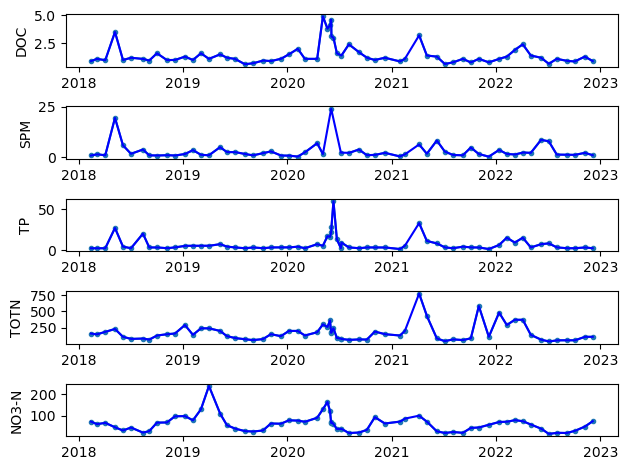

In [43]:
fig, axs = plt.subplots(len(plot_chem_cols))

for i, col in enumerate(chem_df[plot_chem_cols].columns):
    axs[i].plot(chem_df[col], label='Obs', marker='o', ms=3)
    axs[i].plot(chem_daily_df[col], color='b', label='Interpolated')
    axs[i].set_ylabel(col)
    # axs[i].legend()

plt.tight_layout()
plt.show()

### DOC from FDOM

**NOT DONE**

In [ ]:
fluxes_daily_df = df.loc[:, ['Q', 'FDOM', 'Turbidity']]
fluxes_daily_df = fluxes_daily_df.asfreq('D')

concat_li = []

for var_long in ['DOC_mg_L', 'SPM_mg_L']:
    var = var_long[:3]

    # Remove dodgy 2020 DOC data then interpolate linearly
    if site == 'Malselva':
        interp = chem_df.loc[:, '%s' % var_long].asfreq('D').interpolate()
        interp_extra.name = '%s_interp_extra' % var

        if var == 'DOC':
            interp_monthly = interp_monthly.loc[:'2020-01-31']
            interp_extra = interp_extra.loc[:'2020-01-31']

        concat_li.append(interp_extra)

    concat_li.append(interp_monthly)

# Estimate DOC from FDOM
if site == 'Malselva':

    # Split by freshet vs not
    fluxes_daily_df['freshet'] = fluxes_daily_df.index.month.map(freshet)
    freshet_conc = fluxes_daily_df.loc[fluxes_daily_df['freshet'] == 'Freshet', 'FDOM'] * coeffs_df.loc[1, 'm'] + coeffs_df.loc[1, 'c']
    notfreshet_conc = fluxes_daily_df.loc[fluxes_daily_df['freshet'] == 'Not freshet', 'FDOM'] * coeffs_df.loc[0, 'm'] + coeffs_df.loc[0, 'c']
    DOC_FDOM = pd.concat([notfreshet_conc, freshet_conc], axis=0).sort_index()
    DOC_FDOM.name = 'DOC_sensor'
    concat_li.append(DOC_FDOM)

else:
    # No split by season
    fluxes_daily_df['DOC_sensor'] = (fluxes_daily_df['FDOM']
                                     * reg_params.loc[site, 'DOC']['slope']
                                     + reg_params.loc[site, 'DOC']['intercept'])

# Estimate SPM from turbidity
fluxes_daily_df['SPM_sensor'] = (fluxes_daily_df['Turbidity']
                                 * reg_params.loc[site, 'SPM']['slope']
                                 + reg_params.loc[site, 'SPM']['intercept'])

concat_li.append(fluxes_daily_df)

# Add to master fluxes df
fluxes_daily_df = pd.concat(concat_li, axis=1)

# Calculate fluxes in tonnes/day
for col in ['DOC_interp_monthly', 'DOC_interp_extra', 'DOC_sensor',
            'SPM_interp_monthly', 'SPM_interp_extra', 'SPM_sensor']:
    if col in fluxes_daily_df.columns:
        fluxes_daily_df['flux_%s' % col] = (fluxes_daily_df[col]
                                            * fluxes_daily_df['Q']
                                            * 86400 * 10**-6)

# Fill in any short NaN periods
print(fluxes_daily_df[['FDOM', 'Turbidity']].isna().sum())
fluxes_daily_df = fluxes_daily_df.interpolate(method='linear', axis=0, limit=10)
print(fluxes_daily_df[['FDOM', 'Turbidity']].isna().sum())

fluxes_daily_df.loc['2019-05-01': '2019-05-08']

In [ ]:
chem_df.loc['2020'].plot('TOC_mgC_L', 'DOC_mg_L', marker='o', linestyle='')

## Daily flux plots

In [ ]:
# DOC, 2019
if site == 'Malselva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    st_dt = '2019-04-01'
    end_dt = '2019-07-08'
    tmp_conc_df = fluxes_daily_df.loc[st_dt: end_dt,
                  ['DOC_interp_monthly', 'DOC_interp_extra', 'DOC_sensor']]
    tmp_conc_df.plot(ax=axs[0])
    chem_df.loc[st_dt: end_dt, 'TOC_mgC_L']
    axs[0].set_ylabel('Estimated DOC conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Interpolated, higher frequency',
                          'Estimated from sensor'])

    fluxes_daily_df.loc['2019-04-01': '2019-07-08',
                        ['flux_DOC_interp_monthly', 'flux_DOC_interp_extra', 'flux_DOC_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('DOC flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/DOC_daily_fluxes_%s_freshet-2019.png' % site)

In [ ]:
# SPM, 2019, Målselva
if site == 'Malselva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2019-04-01': '2019-07-08',
                        ['SPM_interp_monthly', 'SPM_interp_extra', 'SPM_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated SPM conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Interpolated, higher frequency',
                          'Estimated from sensor'])

    fluxes_daily_df.loc['2019-04-01': '2019-07-08',
                        ['flux_SPM_interp_monthly', 'flux_SPM_interp_extra', 'flux_SPM_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('SPM flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/SPM_daily_fluxes_%s_freshet-2019.png' % site)

In [ ]:
# DOC, 2018, Målselva
if site == 'Malselva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2018-04-01': '2018-07-08',
                        ['DOC_interp_monthly', 'DOC_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated DOC (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Estimated from sensor'])

    fluxes_daily_df.loc['2018-04-01': '2018-07-08',
                        ['flux_DOC_interp_monthly', 'flux_DOC_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('DOC flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/DOC_daily_fluxes_%s_freshet-2018.png' % site)

In [ ]:
# SPM, 2020, Målselva
if site == 'Malselva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2020-01-01': '2020-12-31',
                        ['SPM_interp_monthly', 'SPM_interp_extra', 'SPM_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated SPM conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples',
                          'Interpolated, higher frequency', 'Estimated from sensor'])

    fluxes_daily_df.loc['2020-01-01': '2020-12-31',
                        ['flux_SPM_interp_monthly', 'flux_SPM_interp_extra', 'flux_SPM_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('SPM flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/SPM_daily_fluxes_%s_2021.png' % site)

In [ ]:
# SPM, 2021, Målselva
if site == 'Malselva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2021-01-01': '2021-12-31',
                        ['SPM_interp_monthly', 'SPM_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated SPM conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Estimated from sensor'])

    fluxes_daily_df.loc['2021-01-01': '2021-12-31',
                        ['flux_SPM_interp_monthly', 'flux_SPM_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('SPM flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/SPM_daily_fluxes_%s_2021.png' % site)

In [ ]:
# DOC, 2018, Storelva
if site == 'Storelva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2018-01-01': '2018-12-31',
                        ['DOC_interp_monthly', 'DOC_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated DOC (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Estimated from sensor'])

    fluxes_daily_df.loc['2018-01-01': '2018-12-31',
                        ['flux_DOC_interp_monthly', 'flux_DOC_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('DOC flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/DOC_daily_fluxes_%s_2018.png' % site)

In [ ]:
# SPM
if site == 'Storelva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2018-01-01': '2018-12-31',
                        ['SPM_interp_monthly', 'SPM_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated SPM conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples',
                          'Sensor-based'])

    fluxes_daily_df.loc['2018-01-01': '2018-12-31',
                        ['flux_SPM_interp_monthly', 'flux_SPM_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('SPM flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/SPM_daily_fluxes_%s_2018.png' % site)

In [ ]:
# SPM, Storelva, 2021
if site == 'Storelva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2021-01-01': '2021-12-31',
                        ['SPM_interp_monthly', 'SPM_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated SPM conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples',
                          'Sensor-based'])

    fluxes_daily_df.loc['2021-01-01': '2021-12-31',
                        ['flux_SPM_interp_monthly', 'flux_SPM_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('SPM flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/SPM_daily_fluxes_%s_2021.png' % site)

## Monthly flux plots

In [ ]:
# fluxes_monthly_df['date'] = fluxes_monthly_df.index
# new_index = fluxes_monthly_df['date'].apply(lambda x: x.strftime('%Y-%m'))
# # new_index = pd.to_datetime(new_index)
# fluxes_monthly_df.set_index(new_index, inplace=True)

# # index = pd.to_datetime(df.index, yearfirst=True)
# # df.index = index

# fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

# for i, var in enumerate(['DOC', 'SPM']):
#     if var == 'DOC':
#         legend=True
#     else:
#         legend=False
#     fluxes_monthly_df[['flux_%s_interp_monthly' % var,
#                        'flux_%s_interp_extra' % var,
#                        'flux_%s_sensor' % var]].plot(kind='bar',
#                                                      figsize=(10, 5),
#                                                      ax=axs[i], legend=legend)
#     axs[i].set_ylabel('%s load (T/month)' % var)
#     axs[i].set_xlabel('')

# axs[0].legend(labels=['Interpolated, monthly samples', 'Interpolated, higher frequency',
#                       'Estimated from sensor'])
#     # #set ticks every week
#     # axs[i].xaxis.set_major_locator(mdates.MonthLocator())
#     # #set major ticks format
#     # axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))

In [ ]:
if site == 'Malselva':
    col_li = ['flux_DOC_interp_monthly', 'flux_DOC_interp_extra',
              'flux_DOC_sensor', 'flux_SPM_interp_monthly',
              'flux_SPM_interp_extra', 'flux_SPM_sensor']
else:
    col_li = ['flux_DOC_interp_monthly', 'flux_DOC_sensor',
              'flux_SPM_interp_monthly', 'flux_SPM_sensor']

fluxes_monthly_df = fluxes_daily_df.loc[:, col_li].resample('M').sum()

index = pd.to_datetime(fluxes_monthly_df.index)
fluxes_monthly_df.index = index

# Write to csv
fluxes_monthly_df.to_csv(r'../data/fluxes_monthly_%s.csv' % site)

# Plot
yr_li_dict = {'Malselva': {'DOC': [2018, 2019],
                           'SPM': [2018, 2019, 2020, 2021]},
              'Storelva': {'DOC': [2018, 2019, 2020, 2021],
                           'SPM': [2018, 2019, 2020, 2021]}}

for var in ['DOC', 'SPM']:
    yr_li = yr_li_dict[site][var]
    fig, axs = plt.subplots(1, len(yr_li), sharey=True, figsize=(10, 3))
    for i, yr in enumerate(yr_li):
        if yr == 2019 and site == 'Malselva':
            yr_df = fluxes_monthly_df.loc[fluxes_monthly_df.index.year == yr,
                                          ['flux_%s_sensor' % var,
                                           'flux_%s_interp_monthly' % var,
                                           'flux_%s_interp_extra' % var]]

        elif yr == 2020 and site == 'Malselva' and var == 'SPM':
            yr_df = fluxes_monthly_df.loc[fluxes_monthly_df.index.year == yr,
                                          ['flux_%s_sensor' % var,
                                           'flux_%s_interp_monthly' % var,
                                           'flux_%s_interp_extra' % var]]

        else:
            yr_df = fluxes_monthly_df.loc[fluxes_monthly_df.index.year == yr,
                                          ['flux_%s_sensor' % var,
                                           'flux_%s_interp_monthly' % var]]
        yr_df.index = yr_df.index.month
        yr_df.plot(kind='bar', ax=axs[i], legend=False)
        axs[i].set_ylabel('%s load (T/month)' % var)
        axs[i].set_xlabel(yr)
        axs[i].tick_params(axis='x', labelrotation=0)

    if var == 'DOC':
        if site == 'Malselva':
            axs[-1].legend(labels=['Sensor', 'Interpolated, monthly',
                           'Interpolated, extra'])
        else:
            axs[-1].legend(labels=['Sensor', 'Interpolated, monthly'],
                          prop={'size': 8})

    if var == 'SPM':
        axs[i].set_yscale("log")
    plt.tight_layout()
    plt.savefig(r'../figures/monthly_fluxes_%s_%s.png' % (site, var))

## Annual fluxes

In [ ]:
# Read in annual fluxes calculated using Ospar method
fluxes_ospar_df = pd.read_excel(r'../data/Ospar_Fluxes_bothstations.xlsx')
fluxes_ospar_df.columns = ['site', 'year', 'ospar_DOC_extra', 'ospar_DOC_monthly', 'ospar_SPM_extra', 'ospar_SPM_monthly']
fluxes_ospar_df = fluxes_ospar_df.loc[fluxes_ospar_df['site'] == site]
fluxes_ospar_df.set_index('year', inplace=True)
fluxes_ospar_df.drop('site', axis=1, inplace=True)

# Convert units to 10^3 Tonnes/yr
fluxes_ospar_df = fluxes_ospar_df/10**6

if site == 'Malselva':
    # Drop values that are the same
    fluxes_ospar_df.loc[[2018, 2021], 'ospar_SPM_extra'] = np.NaN
    fluxes_ospar_df.loc[[2018, 2020, 2021], 'ospar_DOC_extra'] = np.NaN
    # Drop dodgy 2020-2021 DOC data
    fluxes_ospar_df.loc[[2020, 2021], 'ospar_DOC_monthly'] = np.NaN

fluxes_ospar_df

In [ ]:
fluxes_yr_df = fluxes_daily_df.loc[:, col_li].resample('Y').sum()
# Convert to kilotonnes (10^3 tonnes/year)
fluxes_yr_df = fluxes_yr_df/10**3

fluxes_yr_df.index = fluxes_yr_df.index.year

# Add Ospar estimates
fluxes_yr_df = pd.concat([fluxes_yr_df, fluxes_ospar_df], axis=1)

# Remove estimates based on grab samples for 2020 and 2021 (almost no data)
if site == 'Malselva':
    fluxes_yr_df.loc[[2020, 2021], ['flux_DOC_interp_monthly', 'flux_DOC_interp_extra']] = np.NaN
    fluxes_yr_df.loc[[2020, 2021], ['flux_DOC_sensor']] = np.NaN  # 2020 only has half a year
    # Also remove 'interpolated_extra' fluxes for 2018 and 2020 for Målselva
    fluxes_yr_df.loc[[2018, 2021], ['flux_DOC_interp_extra', 'flux_SPM_interp_extra']] = np.NaN
    # Turbidity was only measured from mid-2018, so drop
    fluxes_yr_df.loc[2018, 'flux_SPM_sensor'] = np.NaN

if site == 'Storelva':
    fluxes_yr_df.loc[2022, :] = np.NaN

fluxes_yr_df.dropna(how='all', inplace=True)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(3, 4))

for i, var in enumerate(['DOC', 'SPM']):
    if site == 'Malselva':
        var_li = ['flux_%s_sensor' % var,
                  'flux_%s_interp_monthly' % var,
                  'ospar_%s_monthly' % var,
                  'flux_%s_interp_extra' % var,
                  'ospar_%s_extra' % var]
    else:
        var_li = ['flux_%s_sensor' % var,
                  'flux_%s_interp_monthly' % var,
                  'ospar_%s_monthly' % var]

    fluxes_yr_df[var_li].plot(kind='bar',
                              ax=axs[i], legend=False)

    axs[i].set_ylabel('%s load (10$^3$ T/year)' % var)
    axs[i].set_xlabel('')

# plt.tight_layout()

if site == 'Malselva':
    legend = axs[1].legend(labels=['Sensor',
                                   'Interpolated, monthly',
                                   'Ospar, monthly',
                                   'Interpolated, extra',
                                   'Ospar, extra'],
                 loc='right', bbox_to_anchor=(0.9, -0.8),
                 fancybox=True)
else:
    legend = axs[1].legend(labels=['Sensor',
                                   'Interpolated, monthly',
                                   'Ospar'],
             loc='right', bbox_to_anchor=(0.9, -0.8),
             fancybox=True)
title = plt.suptitle("%s" % site_name_dict[site], size=11);

plt.savefig(r'../figures/fluxes_annual_%s.png' % site, bbox_extra_artists=(legend, title), bbox_inches='tight')

In [ ]:
fluxes_yr_df.to_csv(r'../data/fluxes_annual_%s.csv' % site)

In [ ]:
fluxes_yr_df

# To do

* Double-check summer time vs winter time for both sensors and grab samples
* Use raw Q data downloaded from NVE by me
* Add 2020-2022 FDOM data for Målselva. Correct for any step changes, etc.
* Look into NIVA DOC data from 2020 onwards. What's going on?! Dodgy across all sites/programmes? And what about TOC, often DOC > TOC! Which years is this the case for?
* Look further into FDOM corrections (turbidity, and even internal shielding effect of high DOM on FDOM). Ask Benoit D for advice.
* Split into different periods: baseflow, snow melt, summer/autumn flow events. See e.g. SimplyP paper and code for ideas.
* Look at QC relationships with grab samples as well as sensor data? Double-check see similar things.
* For hysteresis, try out this python package:https://pypi.org/project/hysteresis/ (or this R package looks like it could be useful: https://cran.r-project.org/web/packages/hysteresis/vignettes/index.html)
* Calculate fluxes using logCQ relationships. As good as sensor-based estimates?